In [18]:
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Softmax, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
import tensorflow as tf
import datetime
import tensorboard
import matplotlib.pyplot as plt
from sklearn.metrics import auc
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_validate
from scikeras.wrappers import KerasClassifier


#array de colunas


In [19]:
weeks1 = pd.read_csv('../data_raw/dados/2016-1/tabela processada nota media mediana iteracao.csv')
features = ['Aprovado']

for i in range(18):
  features.append(f'Week{i}')
  features.append(f'MedianaW{i}')
  features.append(f'MediaW{i}')
how = ['first']

for i in range(18*3):
  how.append(f'last')

dict_agg = dict(zip(features,how))

weeks2_semnotas = pd.read_csv('../data_raw/dados/2016-2/tabela final .csv')
weeks2_comnotas = pd.read_csv('../data_raw/dados/2016-2/tabela de iteracoes com nota add.csv')
#weeks2 = weeks2_semnotas.join(weeks2_comnotas,on='Nome',how='inner')
weeks2_raw = pd.concat([weeks2_semnotas, weeks2_comnotas])
weeks2 = weeks2_raw.groupby(weeks2_raw['Nome']).agg(dict_agg)
weeks2.dropna(inplace=True)
weeks3 = pd.read_csv('../data_raw/dados/2017-1/tabela final.csv')
weeks4 = pd.read_csv('../data_raw/dados/2017-2/tabela com media mediana e interacao e nota.csv')

weeks_raw =  [weeks1, weeks2, weeks3, weeks4]


In [20]:
def weeks_formating(weeks):
  
  weeks.fillna(0, inplace=True)
  weeks.drop(['Unnamed: 0.1','Notas', 'Unnamed: 0', 'Nome'], inplace=True, axis=1, errors='ignore')
  weeks['Aprovado'] = pd.Categorical(weeks['Aprovado'])
  weeks['Aprovado'] = weeks.Aprovado.cat.codes
  weeks = (weeks
          .replace('\$\s+','', regex=True)
          .astype(float)
          .applymap('{:.2f}'.format))
  weeks = weeks.astype(float)
  weeks_lbl = weeks['Aprovado']
  count_zero = (weeks['Aprovado'] == 0).sum()
  count_one = (weeks['Aprovado'] == 1).sum()
  print(count_zero, count_one)
  return weeks, weeks_lbl

In [21]:
def oversample_data(X_train, y_train):
  smote = SMOTE(k_neighbors=1)
  X_oversample, y_oversample = smote.fit_resample(X_train, y_train)
  print(len(y_train))
  return X_oversample, y_oversample

In [22]:
def weeks_data(data, weeks_num):

  features = []

  for i in range(weeks_num):
    features.append(f'Week{i}')
    features.append(f'MedianaW{i}')
    features.append(f'MediaW{i}')
    
  features.append(f'Aprovado')
  features.remove('Aprovado')
  weeks = data.loc[:,features]
  weeks = weeks.to_numpy()
  return weeks

In [23]:
def build_model(weeks_num):
    opt = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model = Sequential()
    model.add(LSTM(30, input_shape=(weeks_num, 3)))
    model.add(Dense(1, activation='sigmoid'))
    #model.add(Softmax(1))
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=["accuracy"])
    return model


In [24]:
weeks_auc = list()
weeks_num = 8
weeks_num_lst = list(range(0,weeks_num))
semester_lst = list()


In [25]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier


mode = ''
for j in range (2):
  if j == 0:
    mode = 'LSTM'
  if j == 1:
    mode = 'AdaBoost'
  for week in weeks_raw:
    weeks, label = weeks_formating(week)
    weeks_auc = list()
    X, y = oversample_data(weeks, label)

    for i in range(weeks_num):

      X_i = weeks_data(X, i+1)

      # model = KerasClassifier(model=build_model(i+1), epochs=5, batch_size=3, verbose=0)
      # dentro do for: clear session, complie model, fit no kerasclassifier, usar o predict_proba(), agregar em yhat
      # fora do for: usar a func dada, jogar na auc
      # scores = cross_validate(model, X, y, scoring='neg_mean_absolute_error', cv=loo, n_jobs=-1
    
      if mode=='LSTM':
        X_i = X_i.reshape(len(X_i), i+1, 3)

        loo = LeaveOneOut()

        y_true, y_pred =  list(), list()
        
        for train_ix, test_ix in loo.split(X_i):
            tf.keras.backend.clear_session()
            # split data
            X_train, X_test = X_i[train_ix, :], X_i[test_ix, :]
            y_train, y_test = y[train_ix], y[test_ix]
            # fit model
            model = KerasClassifier(model=build_model(i+1))
            model.fit(X_train, y_train, epochs=5,batch_size=3, verbose=0)
            # evaluate model
            yhat = model.predict_proba(X_test)
            # store
            yhat = np.array(yhat).squeeze()
            test_i = y_test.item()
            y_true.append(test_i)
            result = np.where(yhat[1] > 0.5, 1, 0) #<--to get the binary category
            y_pred.append(float(result.item()))

      if mode=='AdaBoost':
        loo = LeaveOneOut()

        y_true, y_pred =  list(), list()
        
        for train_ix, test_ix in loo.split(X_i):
            tf.keras.backend.clear_session()
            # split data
            X_train, X_test = X_i[train_ix, :], X_i[test_ix, :]
            y_train, y_test = y[train_ix], y[test_ix]
            # fit model
            model = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=200)
            model.fit(X_train, y_train)
            # evaluate model
            yhat = model.predict_proba(X_test)
            # store
            yhat = np.array(yhat).squeeze()
            test_i = y_test.item()
            y_true.append(test_i)
            result = np.where(yhat[1] > 0.5, 1, 0) #<--to get the binary category
            y_pred.append(float(result.item()))
      fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_true,y_pred)
      auc_keras = auc(fpr_keras, tpr_keras)
      weeks_auc.append(auc_keras)
    semester_lst.append(weeks_auc)

7 22
29
1/1 [==============================] - 0s 233ms/step
6 18
24
1/1 [==============================] - 0s 232ms/step
10 27
37
1/1 [==============================] - 0s 231ms/step
12 20
32
1/1 [==============================] - 0s 232ms/step
7 22
29
6 18
24
10 27
37
12 20
32


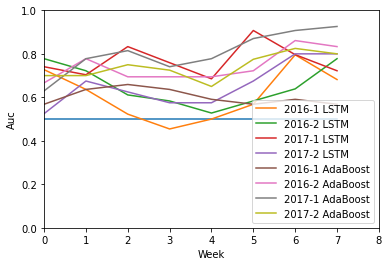

In [26]:
semester_dict = {0:'2016-1 LSTM', 1:'2016-2 LSTM', 2:'2017-1 LSTM', 3:'2017-2 LSTM', 4:'2016-1 AdaBoost', 5:'2016-2 AdaBoost', 6:'2017-1 AdaBoost', 7:'2017-2 AdaBoost'}
plt.plot(weeks_num_lst, [0.5]*weeks_num)

for j in range(8):
  plt.plot(weeks_num_lst, semester_lst[j], label=semester_dict[j])
plt.xlabel('Week')
plt.ylabel('Auc')
plt.ylim(0, 1)
plt.xlim(0,weeks_num)
plt.legend()
plt.show()

In [27]:
print(semester_lst)

[[0.7272727272727273, 0.6363636363636364, 0.5227272727272728, 0.45454545454545453, 0.5, 0.5681818181818181, 0.7954545454545454, 0.6818181818181818], [0.7777777777777778, 0.7222222222222222, 0.611111111111111, 0.5833333333333333, 0.5277777777777778, 0.5833333333333334, 0.6388888888888888, 0.7777777777777777], [0.7407407407407408, 0.7037037037037037, 0.8333333333333334, 0.7592592592592593, 0.6851851851851852, 0.9074074074074074, 0.7962962962962963, 0.7222222222222222], [0.525, 0.6750000000000002, 0.625, 0.575, 0.575, 0.6749999999999999, 0.8, 0.8], [0.5681818181818181, 0.6363636363636365, 0.6590909090909092, 0.6363636363636365, 0.5909090909090908, 0.5681818181818181, 0.590909090909091, 0.5681818181818182], [0.6666666666666667, 0.7777777777777779, 0.6944444444444443, 0.6944444444444443, 0.6944444444444443, 0.7222222222222223, 0.8611111111111112, 0.8333333333333333], [0.6296296296296297, 0.7777777777777778, 0.8148148148148149, 0.7407407407407407, 0.7777777777777778, 0.8703703703703703, 0.90